<a href="https://colab.research.google.com/github/Piquelin/tp_data_mining_solo/blob/main/TP_Individual_JuanValle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%capture
pip install contextily

In [4]:
%%capture
pip install geopandas

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np

# sklearn
import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# mapas
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import contextily as cx
from contextily import Place


# Lectura de datos

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
DIR = "/content/drive/MyDrive/TP_datamining_solo/"

df_train = pd.read_parquet(DIR + "properati_entrenamiento.parquet")  
df_train.index = df_train['id']
df_train.drop(columns='id', inplace=True)
#df_train.head()

df_test = pd.read_csv(DIR + "properati_a_predecir.zip", index_col="id")  
#df_test.head()

In [8]:
print(df_train.shape)
print(df_test.shape)

(994000, 24)
(6000, 24)


# Entendimiento (magia parte 1 -- AID)

In [9]:
df_train = df_train[df_train['price'].notna()]

In [10]:
compare = pd.DataFrame()
compare['dtypes_x'] =  df_train.dtypes
compare['dtypes_y'] =  df_test.dtypes
compare['unicos_x'] =  df_train.nunique()
compare['unicos_y'] =  df_test.nunique()
compare['nulos_x'] =  df_train.isna().sum()
compare['nulos_y'] =  df_test.isna().sum()

compare


,dtypes_x,dtypes_y,unicos_x,unicos_y,nulos_x,nulos_y
ad_type,object,object,1,1,0,0
start_date,object,object,346,342,0,0
end_date,object,object,450,396,0,0
created_on,object,object,346,342,0,0
lat,float64,float64,297809,4152,146944,456
lon,float64,float64,296519,4151,146010,455
l1,object,object,4,1,0,0
l2,object,object,42,2,0,0
l3,object,object,1165,58,54756,211
l4,object,object,951,13,731572,5541


In [11]:
df_test['l2'].value_counts()

Capital Federal           5703
Bs.As. G.B.A. Zona Sur     297
Name: l2, dtype: int64

In [12]:
# for columna in df_test.columns:
#     print(f'\nColumna={columna}\n' ,df_test[f'{columna}'].describe())


In [13]:
for columna in df_test.columns:
  compare = pd.DataFrame()
  
  compare[f'{columna}_test'] =  df_test[f'{columna}'].value_counts()
  compare[f'{columna}_train'] =  df_train[f'{columna}'].value_counts()
  print(compare)

# currency_train  ars
# drop l1 y ad_type por iguales
# drop l5 y l6 por vacías
# mirar la plata l4 (l3 == 'La Plata' y l2 == caba debe andar)
# test solo tiene 2 y 3 rooms
# faltan bedrooms en test
# faltan baños en test
# surface_total_test
# revisar surface_covered
# chequear titulos repetidos
# price period es ruido

           ad_type_test  ad_type_train
Propiedad          6000         949619
            start_date_test  start_date_train
2019-08-01              153             10545
2019-11-13              118              6262
2019-10-12              113              7739
2019-08-13              102              8041
2020-01-24               98              6782
...                     ...               ...
2019-08-12                1               852
2019-09-08                1               143
2019-09-07                1              1052
2019-12-15                1               218
2019-09-25                1               834

[342 rows x 2 columns]
            end_date_test  end_date_train
9999-12-31           1188          177517
2019-12-23            255           18321
2019-08-14            177           13920
2020-05-20            138            6371
2020-02-13            130            8755
...                   ...             ...
2019-10-06              1              77
2019-09-08

In [ ]:


a = df_test[df_test['description'].isin(df_train['description'])]
a
b = df_train[df_train['description'].isin(df_test['description'])]
b= b.pivot_table(columns=['description','surface_covered', 'lat', 'lon'], values='price',aggfunc='mean' ).T
b= b.reset_index()
b=b[~b.duplicated(subset='description')]

# acá tengo 2000 valores para imputar después de que corra el modelo...
df_merged=pd.merge(left=df_test.reset_index(), right=b, on=['description'], how='left', sort=False,validate='many_to_one')
df_merged.index = df_test.index
a=df_merged.price_y
a

id
556713              NaN
192912    235500.000000
238224              NaN
257134              NaN
521738              NaN
              ...      
323956    327400.083333
519391    167770.000000
80048               NaN
523449    180000.000000
757314              NaN
Name: price_y, Length: 6000, dtype: float64

In [ ]:
compare = pd.DataFrame()
compare['currency_y'] =  df_train.currency.value_counts()
compare['currency_x'] =  df_test.currency.value_counts()
compare

,currency_y,currency_x
USD,724508,6000.0
ARS,220116,NaN
UYU,2085,NaN
PEN,40,NaN


In [ ]:
print(list(df_test.l2.unique()))
print(list(df_test.property_type.unique()))
print(list(df_test.operation_type.unique()))


['Capital Federal', 'Bs.As. G.B.A. Zona Sur']
['Departamento', 'PH']
['Venta']


In [ ]:
# saco columnas no significativas
df_train.drop(['l1', 'l5', 'l6', 'ad_type', 'price_period'], axis=1, inplace=True)
df_test.drop(['l1', 'l5', 'l6', 'ad_type', 'price_period'], axis=1, inplace=True)

# me quedo con ['Departamento', 'PH'] y las mapeo
df_train = df_train[df_train['property_type'].isin(list(df_test.property_type.unique()))]
# mapeo property_type
df_train['property_type'] = df_train['property_type'].map({'Departamento':1, 'PH':2})
df_test['property_type'] = df_test['property_type'].map({'Departamento':1, 'PH':2})


In [ ]:
# columnas_para_imputacion = ['rooms', 'bedrooms', 'bathrooms'] # , 'surface_total', 'surface_covered']
# imp = IterativeImputer(max_iter=3, random_state=42, add_indicator=True, keep_empty_features=True)

# df_t = df_test[columnas_para_imputacion]
# sns.heatmap(df_t.isnull(), cbar=False)
# df_tt = pd.concat([df_t, df])
# df_it_i = pd.DataFrame(imp.fit_transform(df_tt))

# print(df_it_i.head())
# cambios=df_it_i.iloc[:,3:].sum()
# print(f'cambios realizados en df_test = \n{cambios}')

# el imputador me reemplazaba todos por el mismo valor, 
# bedrooms por 1.774818 y bathrooms por 1.434157 que están cerca del promedio
# así que los cambio a mano que es más facil

df_test['bedrooms'] = df_test['bedrooms'].fillna(df_train['bedrooms'].mean())
df_test['bathrooms'] = df_test['bathrooms'].fillna(df_train['bathrooms'].mean())

df_train['bedrooms'] = df_train['bedrooms'].fillna(df_train['bedrooms'].mean())
df_train['bathrooms'] = df_train['bathrooms'].fillna(df_train['bedrooms'].mean())


In [ ]:
# 27/5 elimino outliers de precio y superficie cubierta

# saco precios que no están en dolares
df_train = df_train[df_train['currency'] == 'USD']
df_train.drop(['currency'], axis=1, inplace=True)
df_test.drop(['currency'], axis=1, inplace=True)

# me quedo con las ventas
df_train = df_train[df_train['operation_type'].isin(list(df_test.operation_type.unique()))]
df_train.drop(['operation_type'], axis=1, inplace=True)
df_test.drop(['operation_type'], axis=1, inplace=True)

# selecciono capital y zona sur
df_train = df_train[df_train['l2'].isin(df_test.l2.unique())]

df_train = pd.get_dummies(df_train, columns=['l2'])
df_test = pd.get_dummies(df_test, columns=['l2'])
df_train.rename(columns={'l2_Bs.As. G.B.A. Zona Sur':'l2_La_Plata', 'l2_Capital Federal':'l2_CABA'}, inplace=True)
df_test.rename(columns={'l2_Bs.As. G.B.A. Zona Sur':'l2_La_Plata', 'l2_Capital Federal':'l2_CABA'}, inplace=True)

# se repite mucho y no tiene sentido
lista_out = ['Departamento de 1 ambiente en Venta en Caballito',
             'EMPRENDIMIENTO SCALABRINI ORTIZ']
df_train = df_train[~df_train['title'].isin(lista_out)]
# uno que está de prueba
df_train.drop(206820, inplace=True)


In [ ]:
def mayor_400(valor):
    if valor < 400:
        return valor
    valor = valor/10
    return mayor_400(valor)

mayor_400(47360)

47.36

In [ ]:
df_train.columns

Index(['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l3', 'l4',
       'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'title', 'description', 'property_type', 'l2_La_Plata',
       'l2_CABA'],
      dtype='object')

In [ ]:
# no funcionó!

# def sup_x_habitaciones(df_train):
#     # asigno surface covered con (bedrooms +1) 12  + (bathrooms) 6
#     df_train['surface_covered'].fillna((df_train['bedrooms']*12)+(df_train['bathrooms']*6), inplace=True)
#     return df_train
    
# df_train = sup_x_habitaciones(df_train)
# df_test = sup_x_habitaciones(df_test)


In [ ]:


def limpio_surface(df_train):
    # sustituyo nan de surface_covered(11) y surface_total(10)
    df_train['surface_covered'].fillna(df_train['surface_total'], inplace=True)
    df_train['surface_total'].fillna(df_train['surface_covered'], inplace=True)
    for i in range(len(df_train)):
        # si hay valor > 20 para surface_covered lo reemplazo
        if (df_train.iloc[i,11] < 20):
            if (df_train.iloc[i,10]>20):
                df_train.iloc[i,11] = df_train.iloc[i,10]
        if (df_train.iloc[i,11] > 500):
            if (df_train.iloc[i,10] < 500):
                df_train.iloc[i,11] = df_train.iloc[i,10]
    return df_train

df_train = limpio_surface(df_train)
df_test = limpio_surface(df_test)

for i in range(len(df_test)):
    if (df_test.iloc[i,11] > 400):
         df_test.iloc[i,11] =  mayor_400(df_test.iloc[i,11])



In [ ]:
promedio_cubierto = df_test['surface_covered'].mean()
df_test['surface_covered'].fillna(promedio_cubierto, inplace=True)

promedio_total = df_test['surface_total'].mean()
df_test['surface_total'].fillna(promedio_total, inplace=True)


In [ ]:
# elimino precios sin sentido para el metro cuadrado
df_train['precio_metro'] = df_train['price'].fillna(0)/df_train['surface_covered'].fillna(1)
df_train['precio_metro'] = df_train['precio_metro'].fillna(1)
df_train = df_train[df_train['precio_metro'] > 100]
df_train = df_train[df_train['precio_metro'] < 50000]
df_train = df_train[df_train['surface_covered'] > 20] 


train (100083, 19)
test (6000, 18)


count    100083.000000
mean       2975.346382
std        1245.618791
min         117.391304
25%        2245.454545
50%        2804.878049
75%        3461.538462
max       40625.000000
Name: precio_metro, dtype: float64

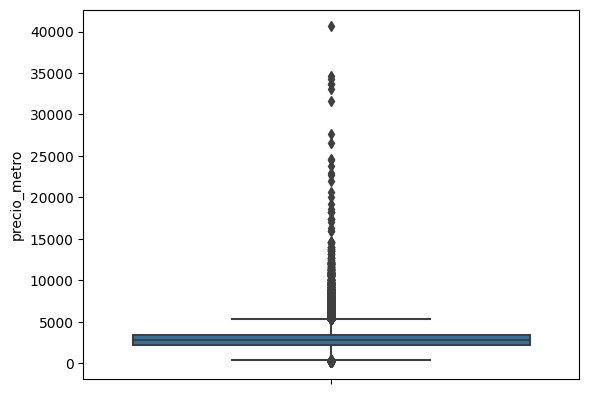

In [ ]:
print('train',df_train.shape) # tengo precio por m2 que al final la saco
print('test',df_test.shape)
sns.boxplot(y=df_train['precio_metro'])
df_train['precio_metro'].describe()

In [ ]:
# https://mudafy.com.ar/d/valor-metro-cuadrado-en-caba-por-barrio
# https://www.iprofesional.com/negocios/343815-departamentos-en-provincia-que-precio-tiene-el-metro-cuadrado
#crear tiene nombre de fantasía
barrios_fantasia = {'Abasto':'Almagro', 'Once':'Balvanera', 'Catalinas':'Barracas',
                    'Parque Centenario':'Caballito', 'Velez Sarsfield':'Liniers',
                    'Congreso':'Monserrat', 'Centro / Microcentro': 'Monserrat', 
                    'Las Cañitas':'Palermo', 'Barrio Norte':'Recoleta', 
                    'Tribunales':'Versalles'}

precio_barrio = {'Agronomía':3.2,'Almagro':3.4,'Balvanera':2.8,'Barracas':3.0,
                 'Belgrano':4.3,'Boedo':3.1,'Caballito':3.7,'Chacarita':3.3,
                 'Coghlan':3.6,'Colegiales':3.8,'Constitución':2.3,'Flores':3.1,
                 'Floresta':2.9,'Boca':2.3,'Liniers':3.0,'Mataderos':2.8,
                 'Monserrat':2.9,'Monte Castro':3.1,'Pompeya':2.2,'Nuñez':4.0,
                 'Palermo':4.2,'Parque Avellaneda':2.5,'Parque Chacabuco':3.1,
                 'Parque Chas':3.3,'Parque Patricios':2.7,'Paternal':2.9,
                 'Puerto Madero':6.0,'Recoleta':4.0,'Retiro':3.4,'Saavedra':3.8,
                 'San Cristobal':2.9,'San Nicolás':2.9,'San Telmo':3.1,
                 'Versalles':2.9,'Villa Crespo':3.4,'Villa del Parque':3.4,
                 'Villa Devoto':3.5,'Villa General Mitre':3.0,'Villa Lugano':2.1,
                 'Villa Luro':3.0,'Villa Ortuzar':3.2,'Villa Pueyrredón':3.4,
                 'Villa Real':3.2,'Villa Riachuelo':2.0,'Villa Santa Rita':3.0,
                 'Villa Soldati':1.8,'Villa Urquiza':3.9,'La Plata':2.8,
                 'Abasto':3.4,
                 'Barrio Norte':4.0,'Catalinas':3.0,'Centro / Microcentro':2.9,
                 'Congreso':3.1,'Distrito Audiovisual':3.0,'Las Cañitas':4.2,
                 'Once':2.8,'Parque Centenario':3.7,'Tribunales':2.9,
                 'Velez Sarsfield':3.4,}

# 'Abasto':3.4,
# 'Barrio Norte':4.0,'Catalinas':3.0,'Centro / Microcentro':2.9,
# 'Congreso':3.1,'Distrito Audiovisual':3.0,'Las Cañitas':4.2,
# 'Once':2.8,'Parque Centenario':3.7,'Tribunales':2.9,
# 'Velez Sarsfield':3.4,

In [ ]:
# len(centroides)
# len(precio_barrio)

# import unicodedata

# unicodedata.normalize('NFKD', string_1).encode('ASCII', 'ignore').strip().lower() == unicodedata.normalize('NFKD', string_2).encode('ASCII', 'ignore').strip().lower()

In [ ]:
# archivo_barrios='https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.zip'
# barrios = gpd.read_file(archivo_barrios)

# # fig, ax = plt.subplots(1, figsize=(3, 3))
# # barrios.plot(ax=ax, alpha=0.1, edgecolor='k', color='r')
# # barrios.centroid.plot(ax=ax)

# centroides = pd.DataFrame(zip(barrios.sort_values(by='BARRIO')['BARRIO'],
#                               barrios.sort_values(by='BARRIO').centroid.y,
#                               barrios.sort_values(by='BARRIO').centroid.x),
#                            columns=['Barrio', 'lat', 'lon'])
# centroides = centroides.append({'Barrio':'La Plata', 'lat': -34.920863104693,'lon':-57.9540560062469}, ignore_index=True)

# La Plata centroide:{"lat":-34.920863104693,"lon":-57.9540560062469

In [ ]:
%%time

def precio_barrios(df_train):
    # reemplazo por precios de metro2 de mudafy
    for i in range(len(df_train)):
        if df_train.iloc[i,16] == True:
            df_train.iloc[i,5] = 'La Plata'
    df_train.replace({'l3':precio_barrio}, inplace=True)
    return df_train

df_train = precio_barrios(df_train).drop(['l4'], axis=1)
df_test =  precio_barrios(df_test).drop(['l4'], axis=1)



CPU times: user 8.89 s, sys: 113 ms, total: 9 s
Wall time: 11.9 s


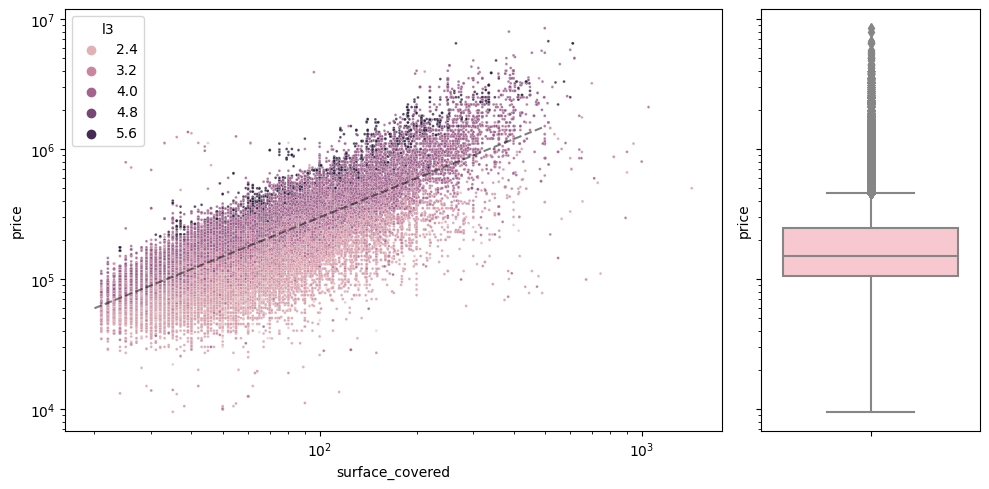

In [ ]:
# grafico para entender distribución
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5), sharey=True,
                              gridspec_kw={'width_ratios': [3, 1]})
sns.scatterplot(data=df_train, x='surface_covered', y = 'price' ,
                hue='l3', alpha=0.8, ax=ax, s=4)
ax.set_yscale('log')
ax.set_xscale('log')

# 2982.69 => Promedio para valores con sentido u$s 3.000 por metro cuadrado
promedio_m2 = round(df_train['precio_metro'].mean(),2)
x = np.linspace(20,500)
ax.plot(x,(x*promedio_m2), linestyle='--', alpha=0.5, color='black',)

sns.boxplot(y=df_train['price'], ax=ax1, color='pink')

fig.tight_layout()



In [ ]:
compare = pd.DataFrame()
compare['unicos_x'] =  df_train.nunique()
compare['unicos_y'] =  df_test.nunique()
compare['nulos_x'] =  df_train.isna().sum()
compare['nulos_y'] =  df_test.isna().sum()
compare


,unicos_x,unicos_y,nulos_x,nulos_y
start_date,346,342.0,0,0.0
end_date,448,396.0,0,0.0
created_on,346,342.0,0,0.0
lat,38596,4152.0,5860,456.0
lon,38414,4151.0,5860,455.0
l3,23,23.0,512,211.0
rooms,23,2.0,4391,0.0
bedrooms,23,7.0,0,0.0
bathrooms,14,7.0,0,0.0
surface_total,584,200.0,0,0.0


In [ ]:

df_train['surface_total'].fillna(df_train['surface_covered'], inplace=True)
df_test['surface_total'].fillna(df_test['surface_covered'], inplace=True)
df_train['rooms'].fillna(df_train['bedrooms']+1, inplace=True)



In [ ]:
#@markdown # Bajo mapa contextily

# Defino Bounding Box de coordenadas de mi mapa
west, south, east, north = [-58.6, -35.2, -57.75, -34.5,]

ghent_img, ghent_ext = cx.bounds2img(west, south, east, north, ll=True, 
                                     source=cx.providers.Stamen.TonerLite)

# a la imagen bajada arriba le paso sistema de coordenadas
warped_img, warped_ext = cx.warp_tiles(ghent_img, ghent_ext, "EPSG:4326")

vista_previa = False #@param {type:'boolean'}
#@markdown ![mapa contextily](https://drive.google.com/uc?export=view&id=1aCqAPWwDHmcvPNM_qakAIHJSOOtfapBi)

if vista_previa:
  fig, ax = plt.subplots(1, figsize=(3, 3))
  ax.imshow(warped_img, extent=warped_ext)

In [ ]:
#@markdown # Bajo mapa municipios

archivo = '/content/drive/MyDrive/TP_datamining_solo/MAPAS/municipios.zip'
municipios = gpd.read_file(archivo)
indice_caba=list(range(len(municipios))).pop(0)
indice_la_plata=list(range(len(municipios))).pop(27)

vista_previa = False #@param {type:'boolean'}

#@markdown ![municipios](https://drive.google.com/uc?export=view&id=1nUv8NxJ_ltd_o-01HhlcDchdE0dosyZr)

if vista_previa:
  fig, ax = plt.subplots(1, figsize=(3, 3))
  # municipios.plot(alpha=0.2, edgecolor='k', ax=ax)
  plt.ylim(-35.2,-34.4)
  plt.xlim( -58.8,-57.75)

  municipios.drop(indice_caba).plot(ax=ax, alpha=0.1, edgecolor='k', color='r')
  municipios.drop(indice_la_plata).plot(ax=ax, alpha=0.1, edgecolor='k', color='b')

  plt.show()

(-10.0, 500000.0)

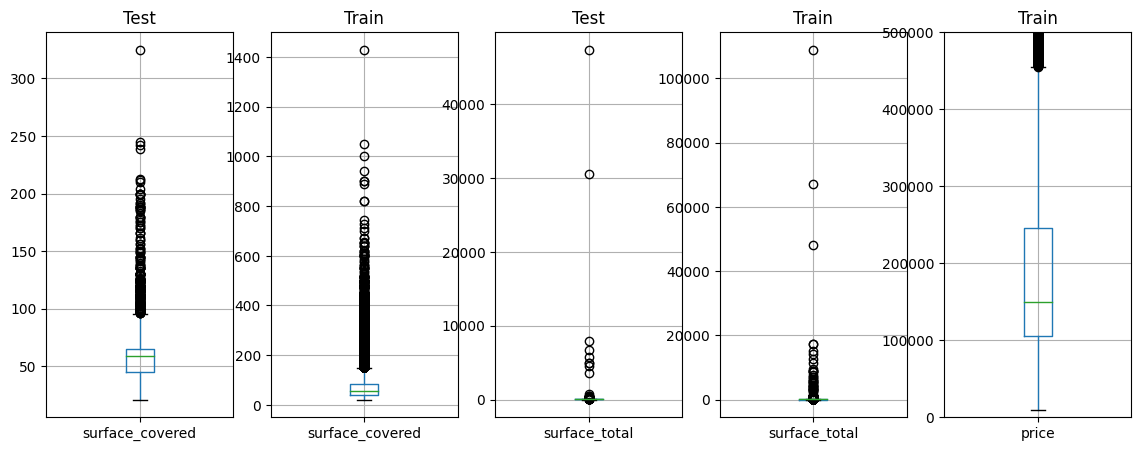

In [ ]:
fig, (ax1,ax2,ax3, ax4, ax5) = plt.subplots(ncols=5, figsize=(14, 5))

df_test.boxplot('surface_covered', ax=ax1)
df_train.boxplot('surface_covered', ax=ax2)
ax1.set_title('Test')
ax2.set_title('Train')
#ax1.set_ylim(-10,400)
#ax2.set_ylim(-10,400)

df_test.boxplot('surface_total', ax=ax3)
df_train.boxplot('surface_total', ax=ax4)
ax3.set_title('Test')
ax4.set_title('Train')
#ax3.set_ylim(-10,400)
#ax4.set_ylim(-10,400)


df_train.boxplot('price', ax=ax5)
ax5.set_title('Train')
ax5.set_ylim(-10,500000)


In [ ]:
# df_train.loc[df_train['price']<1000, 'price'] = np.nan
# df_train.loc[df_train['price']>450000, 'price'] = np.nan

# columnas_para_imputacion = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']
# imp = IterativeImputer(max_iter=10, random_state=42, add_indicator=True, keep_empty_features=True)

# df = df_train[columnas_para_imputacion]
# df_it_i = pd.DataFrame(imp.fit_transform(df))

# print(df_it_i.head())
# cambios=df_it_i.iloc[:,:].sum().astype('int')
# print(f'cambios realizados en df_test = \n{cambios}')


In [ ]:
#@markdown # Ubico lat y lon como coordenadas para mapa

# designate coordinate system
# crs = {'init':'espc:4326'}

# armo puntos para train
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(df_train['lat'], df_train['lon'])]
# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(df_train, geometry = geometry,)

# armo puntos para test
geometry_t = [Point(xy) for xy in zip(df_test['lat'], df_test['lon'])]
geo_test = gpd.GeoDataFrame(df_test, geometry = geometry_t)

In [ ]:
vista_previa = False



if vista_previa:
  # create figure and axes, assign to subplot
  fig, ax = plt.subplots(figsize=(9,9))# add .shp mapfile to axes
  # municipios.drop(indice_muni).plot(ax=ax, alpha=0.1, edgecolor='k')
  # municipios.drop(indice_caba).plot(ax=ax, alpha=0.1, edgecolor='k')
  # municipios.drop(indice_la_plata).plot(ax=ax, alpha=0.1, edgecolor='k')

  # add geodataframe to axes
  # add legend
  # make datapoints transparent using alpha
  # assign size of points using markersize
  
  geo_df.plot(alpha=0.05, ax=ax, legend=True, column='l3', markersize=5 )
  geo_test.plot(alpha=0.1, ax=ax, marker='+', color='pink', legend=False, markersize=1)

  # add title to graph

  plt.title('Estudiando geo_test', fontsize=15,fontweight='bold')
  # set latitiude and longitude boundaries for map display
  plt.ylim(-35.2,-34.5)
  plt.xlim( -58.6,-57.75)

  #extras
  # ax.axhline(y = -34.7, color = 'r', linestyle = '--', alpha=0.5)
  # ax.axhline(y = -34.85, color = 'r', linestyle = '--', alpha=0.5)
  plt.imshow(warped_img, extent=warped_ext,)
  
  # show map
  plt.show()

In [ ]:
# import folium
# # Crear un objeto de mapa centrado en una ubicación específica
# mapa = folium.Map(location=[-34.8, -58.3], zoom_start=12)
# # Agregar un marcador en una ubicación específica
# #folium.Marker([40.7128, -74.0060], popup='Nueva York').add_to(mapa)
# # Mostrar el mapa
# mapa

# Limpieza y transformación de datos (magia parte 2 -- MD)

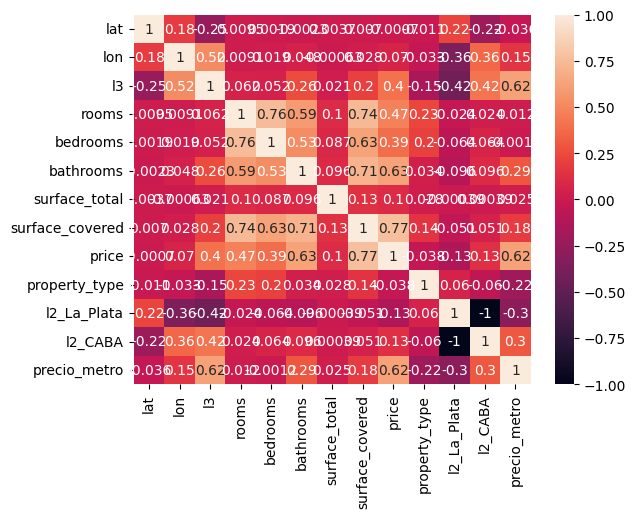

In [ ]:
C = df_train.corr()
s= sns.heatmap(C, annot=True)
# s.set(xlabel='Predicted', ylabel='True class')

In [ ]:
df_train.drop('precio_metro', axis=1, inplace=True)

In [ ]:
## esto tiene que hacerse antes y mejor
# para el gps
# quiero llenar los de la plata con centro en la plata y los de caba por barrio


df_train.fillna(0, inplace=True, downcast= "infer")
df_test.fillna(0, inplace=True, downcast= "infer") 

In [ ]:
# Funcion de limpieza (usada en la siguiente sección) que usa y_train
def limpiar_fold(X_train, y_train, X_test):
    ## TODO: limpiar los datos

# 
    return (X_train, y_train, X_test)

In [ ]:
#@markdown # armo objeto log
from datetime import datetime


archivo_log = "/content/drive/MyDrive/TP_datamining_solo/Log.txt" #@param {type:"string"}
#@markdown - poner nombre de archivo, formato AAAAMMDD_Usuario.txt

cambios = "agregue la trampa de imputacion por titulo" #@param {type:"string"}

#@markdown - En "cambios" hay que poner los cambios de esta versión, poner el bloque de código o explicar que se cambió, que se yo, vamos ajustando eso.


def al_log(texto, archivo=archivo_log):

    with open(archivo, 'a') as f:
        f.write(f'{texto}\n')

al_log('')
al_log(datetime.now())
al_log(cambios)

# Entrenamiento del modelo

## Territorio de Aprendizaje Automático
☢☢☢☢☢☢ Se mira y no se toca ☢☢☢☢☢☢☢

In [ ]:
# Datos para probar
df_train = df_train.select_dtypes(include=['float64', 'int64', 'int32', 'int16', 'int8', 'uint8'])
df_test = df_test.select_dtypes(include=['float64', 'int64', 'int32', 'int16', 'int8', 'uint8'])


X = df_train[df_train.columns.drop('price')]
y = df_train['price']

In [ ]:
# grafico para entender distribución
def dibujo_acc(X_test,y_pred,y_test):
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(7, 3), sharey=False,
                                gridspec_kw={'width_ratios': [3, 4]})
    
    x = np.linspace(50000,6000000)

    sns.scatterplot(data=X_test, y=y_pred, x=y_test, #,palette='Set2'
                    hue='l3', alpha=0.2,ax=ax)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.plot(x,x, linestyle='--', alpha=0.5, color='black')

    sns.scatterplot(data=X_test, y=y_pred, x=y_test, # ,palette='Set2'
                    hue='l3', alpha=0.2,ax=ax1)

    ax1.plot(x,x, linestyle='--', alpha=0.5, color='black')



In [ ]:
%%time
# Creamos el modelo
reg = sk.ensemble.RandomForestRegressor(min_samples_leaf= 15, n_estimators= 100,
                                        max_depth=5, n_jobs=-1, random_state=42)

# Partimos en entrenamiento+prueba y validación
X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

scores_train = []
scores_test = []
lista_ytest = []
lista_ypred = []
lista_xtest = []
# Validación cruzada, 10 folds, shuffle antes
kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(kf.split(X_train_test, y_train_test)):
    X_train, X_test, y_train, y_test = X_train_test.iloc[train_index], X_train_test.iloc[test_index], y_train_test.iloc[train_index], y_train_test.iloc[test_index]

    X_train, y_train, X_test = limpiar_fold(X_train, y_train, X_test)

    # Entrenamos el modelo
    reg.fit(X_train, y_train)

    # Predecimos en train
    y_pred = reg.predict(X_train)

    # Medimos la performance de la predicción en train
    score_train = sk.metrics.mean_squared_error(y_train, y_pred, squared=False)
    scores_train.append(score_train)

    # Predecimos en test
    y_pred = reg.predict(X_test)    

    # Medimos la performance de la predicción en test
    score_test = sk.metrics.mean_squared_error(y_test, y_pred, squared=False)
    scores_test.append(score_test)
    
    print(f"{fold=}, {score_train=:,.1f} {score_test=:,.1f}")
    al_log(f"{fold=}, {score_train=:,.1f} {score_test=:,.1f}")

    lista_ytest.append(y_test)
    lista_ypred.append(y_pred)
    lista_xtest.append(X_test)

print(f"Train scores mean={pd.Series(scores_train).mean():,.1f}, std={pd.Series(scores_train).std():,.1f}")
print(f"Test scores mean={pd.Series(scores_test).mean():,.1f}, std={pd.Series(scores_test).std():,.1f}")
al_log(f"Train scores mean={pd.Series(scores_train).mean():,.1f}, std={pd.Series(scores_train).std():,.1f}")
al_log(f"Test scores mean={pd.Series(scores_test).mean():,.1f}, std={pd.Series(scores_test).std():,.1f}")

fold=0, score_train=126,806.0 score_test=115,909.4
fold=1, score_train=125,481.9 score_test=127,554.3
fold=2, score_train=124,962.5 score_test=114,001.1
fold=3, score_train=123,187.0 score_test=140,638.7
fold=4, score_train=124,698.7 score_test=116,818.0
fold=5, score_train=126,079.9 score_test=124,283.7
fold=6, score_train=125,666.4 score_test=119,441.0
fold=7, score_train=123,906.8 score_test=135,605.5
fold=8, score_train=121,262.9 score_test=143,123.0
fold=9, score_train=123,777.6 score_test=126,020.1
Train scores mean=124,583.0, std=1,612.4
Test scores mean=126,339.5, std=10,419.5
CPU times: user 2min 22s, sys: 421 ms, total: 2min 22s
Wall time: 1min 30s


In [ ]:
activo = False
if activo:
    for i, X_t in enumerate(lista_xtest):
        y_p = lista_ypred[i]
        y_t = lista_ytest[i]
        dibujo_acc(X_t,y_p,y_t)

# Predicción para kaggle


In [ ]:
%%time
## Datos a predecir 
X = df_train[df_train.columns.drop('price')]
y = df_train['price']
X_prueba = df_test[df_train.columns.drop('price')] # cuidado:

# Entrenamos el modelo con todos los datos
reg.fit(X, y)

# Predecimos
df_test['price'] = reg.predict(X_prueba)

# Grabamos
df_test['price'].to_csv('solucion.csv', index=True)

CPU times: user 18.4 s, sys: 37.1 ms, total: 18.4 s
Wall time: 12.8 s


In [ ]:
importancia = pd.DataFrame(zip(df_train.columns.drop('price'), reg.feature_importances_), columns=["column", "feature_importance"]).sort_values(by="feature_importance", ascending=False)
print(importancia)
al_log(importancia)

             column  feature_importance
7   surface_covered            0.751490
2                l3            0.184254
6     surface_total            0.040101
1               lon            0.011083
0               lat            0.007656
3             rooms            0.003178
5         bathrooms            0.001472
8     property_type            0.000703
4          bedrooms            0.000063
9       l2_La_Plata            0.000000
10          l2_CABA            0.000000


In [ ]:
# a = pd.concat([a,df_test['price']], axis=1)
# #a['price_y'].fillna(a['price'], inplace=True)
# # Grabamos
# a['price_y'].to_csv('solucion_y.csv', index=True)


In [ ]:
volver = input('pausa')

pausaf


In [ ]:
cargo_valor_kaggle = True #@param {type:'boolean'}

resultado_kaggle = "132887.91964 no funcon\xF3 como esperaba" #@param {type:"string"}
#@markdown - poner resultado obtenido en kaggle
if cargo_valor_kaggle:
  al_log(f'resultado_kaggle={resultado_kaggle}')


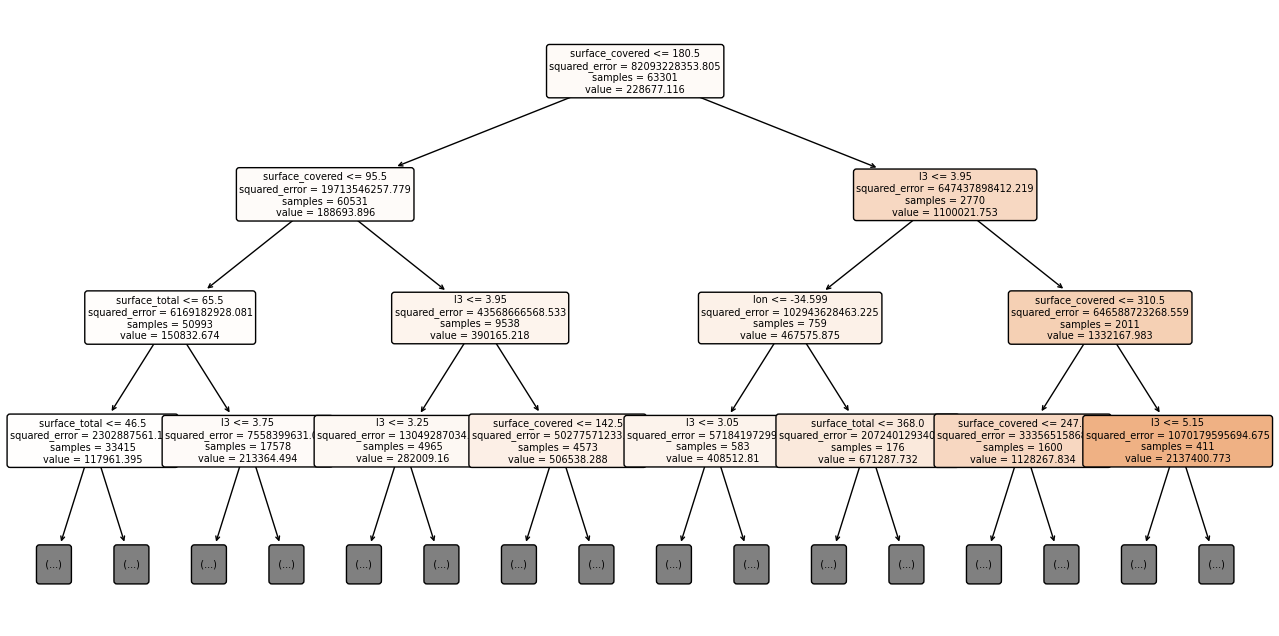

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

features = df_train.columns.drop('price')

fig, ax = plt.subplots(figsize=(16,8))
plot_tree(reg.estimators_[0], filled=True, max_depth=3, feature_names=features,
          rounded=True, fontsize=7, );

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
# from sklearn.svm import SVC, SVR
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor

# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.metrics import r2_score, mean_squared_error
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.model_selection import StratifiedKFold, GridSearchCV
# from sklearn.metrics import make_scorer
# from sklearn.metrics import confusion_matrix, classification_report

In [ ]:



def run_regression_experiment(x_train, y_train, x_test, y_test, model, hyperparameter_grid):
    kfoldcv = StratifiedKFold(n_splits=5)
    model = model
    scorer_fn = make_scorer(mean_squared_error)
    randomcv = GridSearchCV(estimator=model,
                          param_grid=hyperparameter_grid,
                          scoring=scorer_fn,
                          cv=kfoldcv)
    randomcv.fit(x_train, y_train)
    print(f'Best hyperparameters found are: {randomcv.best_params_}')
    best_model = randomcv.best_estimator_
    y_pred = best_model.predict(x_test)
    print('MSE:')
    print(mean_squared_error(y_test,y_pred)/len(y_pred))
    print('R2 score:')
    print(r2_score(y_test,y_pred))
    if "feature_importances_" in model.__dict__:
        print('Feature importances:')
        print(best_model.feature_importances_)
    return y_pred

In [ ]:
# %%time

# rf_grid = {'n_estimators':[100, 300, 500],
#            'n_jobs': [-1],
#            'max_depth': [5, 10],
#            'min_samples_leaf': [1, 5, 15]
#            }
# rf = RandomForestRegressor()
# y_pred_rf = run_regression_experiment(X_train, y_train, X_test, y_test, rf, rf_grid)

# # {'max_depth': 5, 'min_samples_leaf': 15, 'n_estimators': 100, 'n_jobs': -1}

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters found are: {'max_depth': 5, 'min_samples_leaf': 15, 'n_estimators': 100, 'n_jobs': -1}
MSE:
285036.4647790413
R2 score:
0.9739528679410845
CPU times: user 15min 34s, sys: 22 s, total: 15min 56s
Wall time: 1h 8min 58s
